In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

<h1>TRAINING DATASET </h1>

<h3>1. Importing Train Dataset</h3>

In [2]:
df_train = pd.read_csv(r"/kaggle/input/playground-series-s4e7/train.csv")
df_train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


<h3>2. Architecture of Dataset</h3>

In [3]:
df_train.shape

(11504798, 12)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


In [5]:
df_train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.752398e+06,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,3.321149e+06,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.876199e+06,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,5.752398e+06,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,8.628598e+06,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.150480e+07,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


<h3>3. Checking for Duplicates</h3>

In [6]:
print("Number of duplicated rows in dataset : ",df_train.duplicated().sum())

Number of duplicated rows in dataset :  0


<h3>4. Handling Missing Values </h3>

In [7]:
df_train.isna().sum().sort_values(ascending = False)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

<h3>5. EDA Distribution Across All Features</h3>

In [8]:
numerical_df = df_train.select_dtypes(include=['number'])
# numerical_features = numerical_df.columns.tolist()

categorical_df = df_train.select_dtypes(include=['object'])
# categorical_df = categorical_df.columns.to_list()

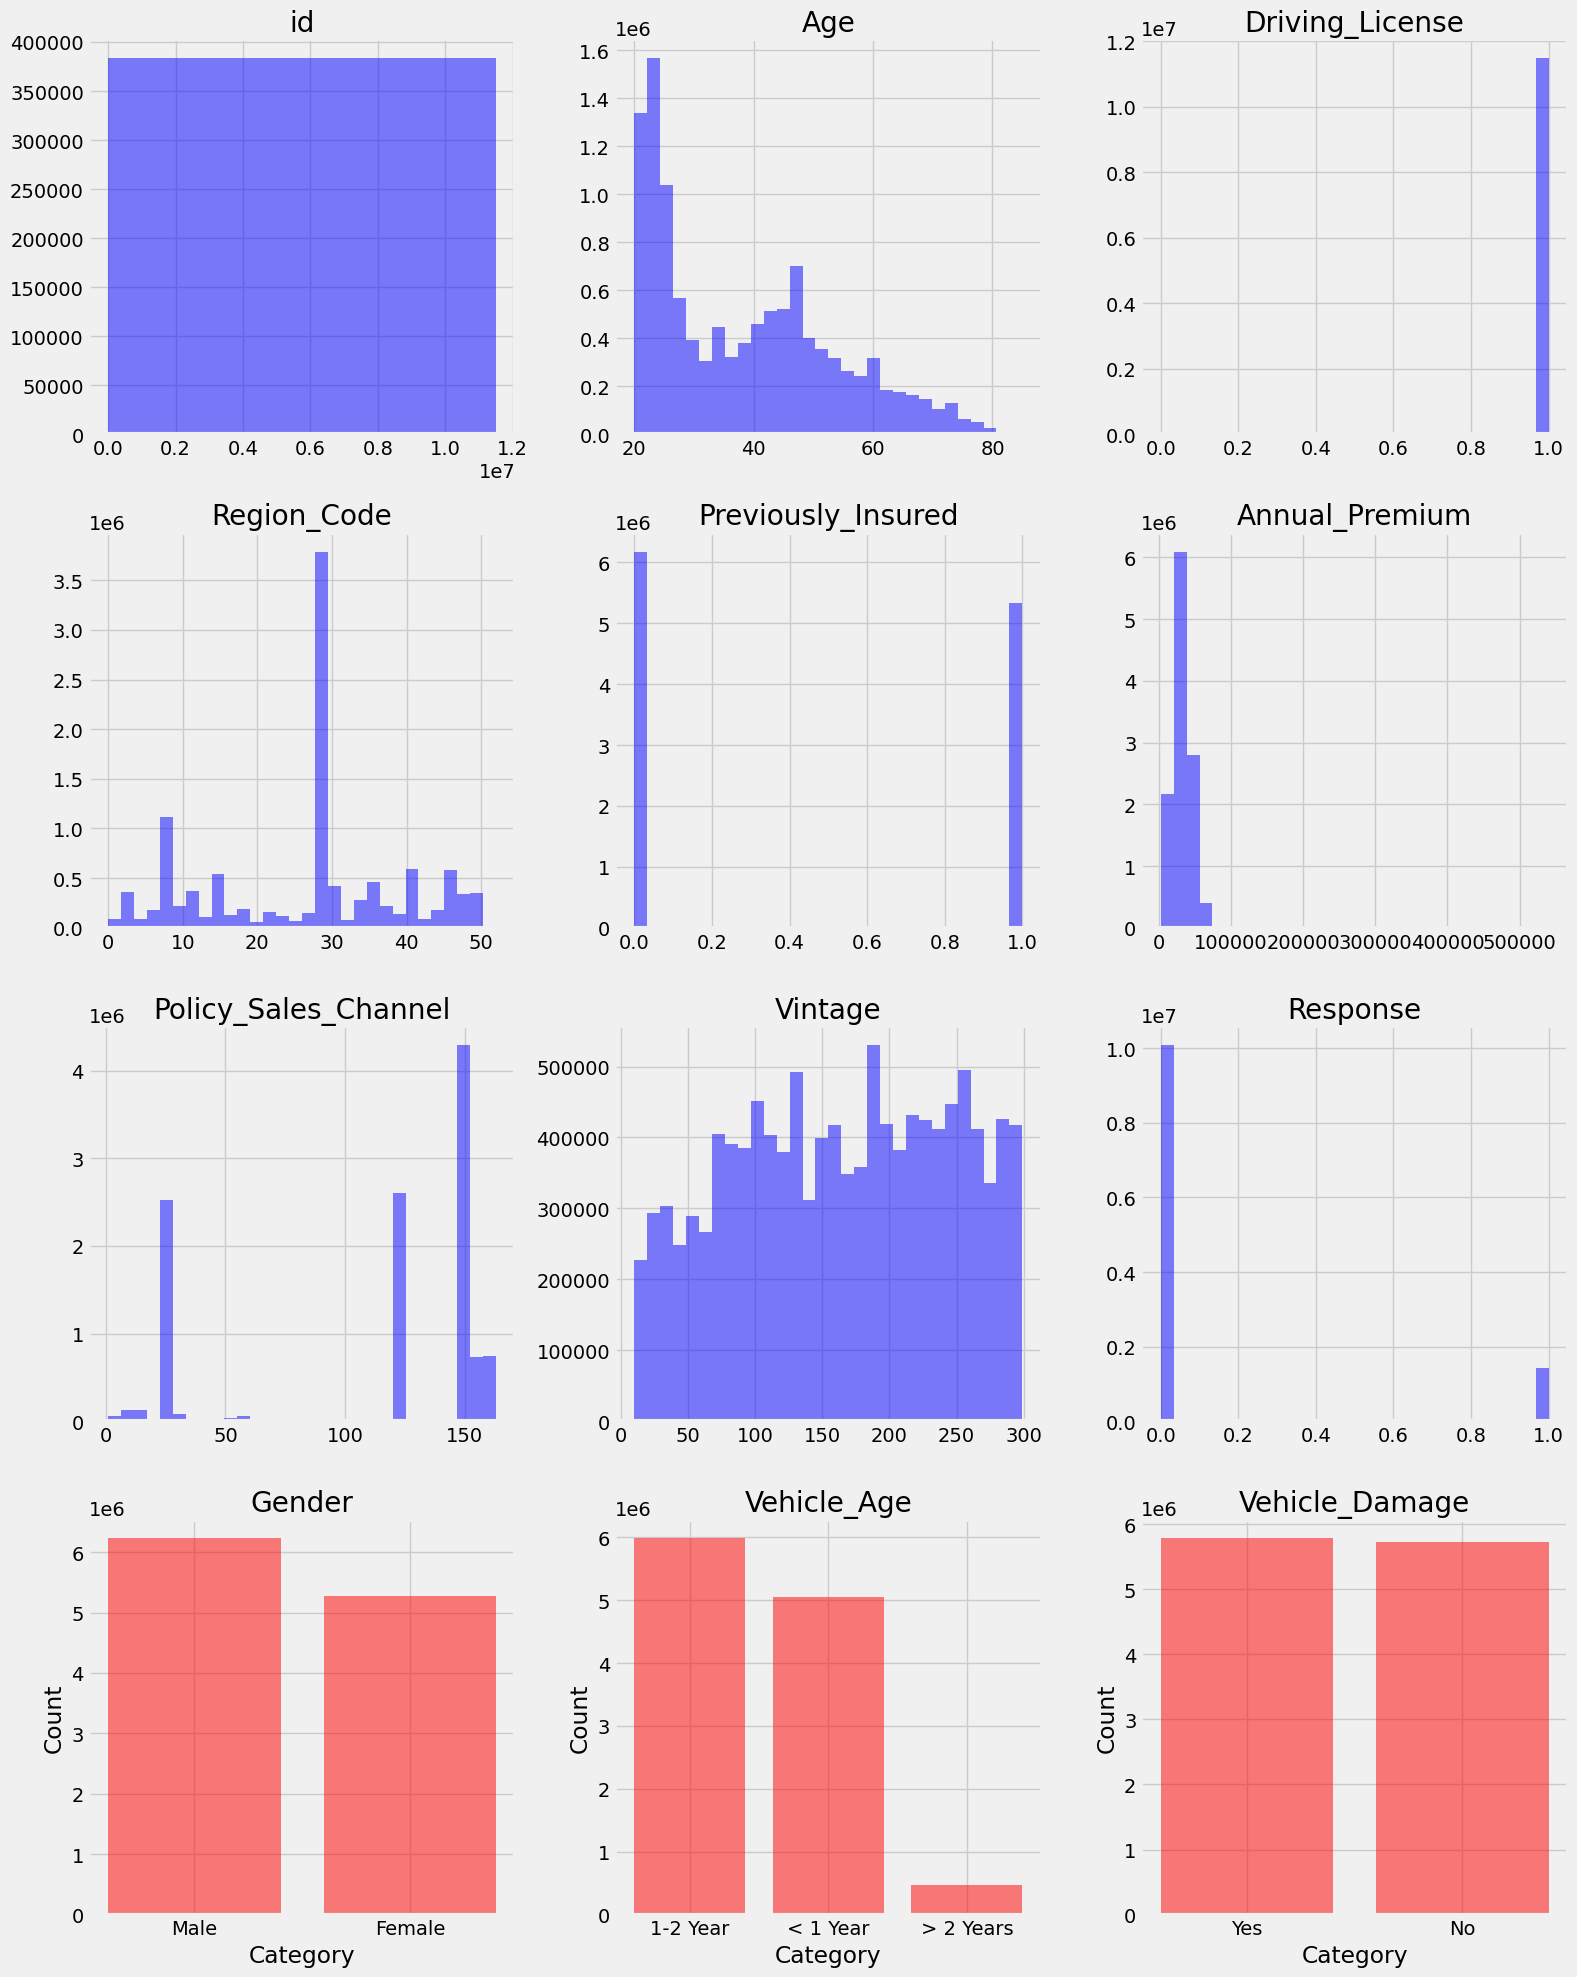

In [9]:
fig, axs = plt.subplots(4, 3, figsize=(16, 20))
axs = axs.flatten()

index = 0

# Loop through each numerical column and plot a histogram
for num_ft in numerical_df.columns:
    ax = axs[index]
    ax.hist(numerical_df[num_ft], bins=30, alpha=0.5, color='blue')
    ax.set_title(num_ft)
    index += 1

# Loop through each categorical column and plot a bar chart of value counts
for cat_ft in categorical_df.columns:
    ax = axs[index]
    # Get the frequency counts for each category
    counts = categorical_df[cat_ft].value_counts()
    # Create a bar chart using the category names as labels
    ax.bar(counts.index.astype(str), counts.values, alpha=0.5, color='red')
    ax.set_title(cat_ft)
    ax.set_xlabel("Category")
    ax.set_ylabel("Count")
    index+=1

plt.tight_layout()
plt.show()

<h3>6. Encode Categorical Columns </h3>

In [10]:
df_train.info()
print('\n')
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB




,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [11]:
for col in categorical_df:
    print(f"{col} has {df_train[col].nunique()} values : {df_train[col].unique()} \n")

Gender has 2 values : ['Male' 'Female'] 

Vehicle_Age has 3 values : ['1-2 Year' '> 2 Years' '< 1 Year'] 

Vehicle_Damage has 2 values : ['Yes' 'No'] 



<h4>GENDER </h4>

In [12]:
# Binary features
# Display the unique values before encoding 
print("Before encoding:", df_train['Gender'].unique())

le = LabelEncoder()
df_train['Gender'] = le.fit_transform(df_train['Gender'])  # Male = 1, Female = 0

# Verify the transformation 
print("After encoding:", df_train['Gender'].unique())

Before encoding: ['Male' 'Female']
After encoding: [1 0]


<h4>VEHICLE AGE</h4>

In [13]:
# View unique values before encoding
print("Before encoding:", df_train['Vehicle_Age'].unique())

# Initialize OrdinalEncoder with explicit category order
ord_enc = OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']])

# Apply the encoding and overwrite the existing column
df_train['Vehicle_Age'] = ord_enc.fit_transform(df_train[['Vehicle_Age']])

# Optional: Confirm encoding worked
print("After encoding:", df_train['Vehicle_Age'].unique())

Before encoding: ['1-2 Year' '> 2 Years' '< 1 Year']
After encoding: [1. 2. 0.]


<h4>VEHICLE DAMAGE</h4>

In [14]:
# View unique values before encoding
print("Before encoding:", df_train['Vehicle_Damage'].unique())

# Encode Vehicle_Damage: Yes = 1, No = 0
df_train['Vehicle_Damage'] = le.fit_transform(df_train['Vehicle_Damage'])  

# Optional: Check result
print("After encoding:", df_train['Vehicle_Damage'].unique())

Before encoding: ['Yes' 'No']
After encoding: [1 0]


In [15]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35.0,0,1.0,1,65101.0,124.0,187,0
1,1,1,43,1,28.0,0,2.0,1,58911.0,26.0,288,1
2,2,0,25,1,14.0,1,0.0,0,38043.0,152.0,254,0
3,3,0,35,1,1.0,0,1.0,1,2630.0,156.0,76,0
4,4,0,36,1,15.0,1,1.0,0,31951.0,152.0,294,0


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                int64  
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           float64
 7   Vehicle_Damage        int64  
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(4), int64(8)
memory usage: 1.0 GB


<h3>7. Pearson Correlation Matrix</h3>

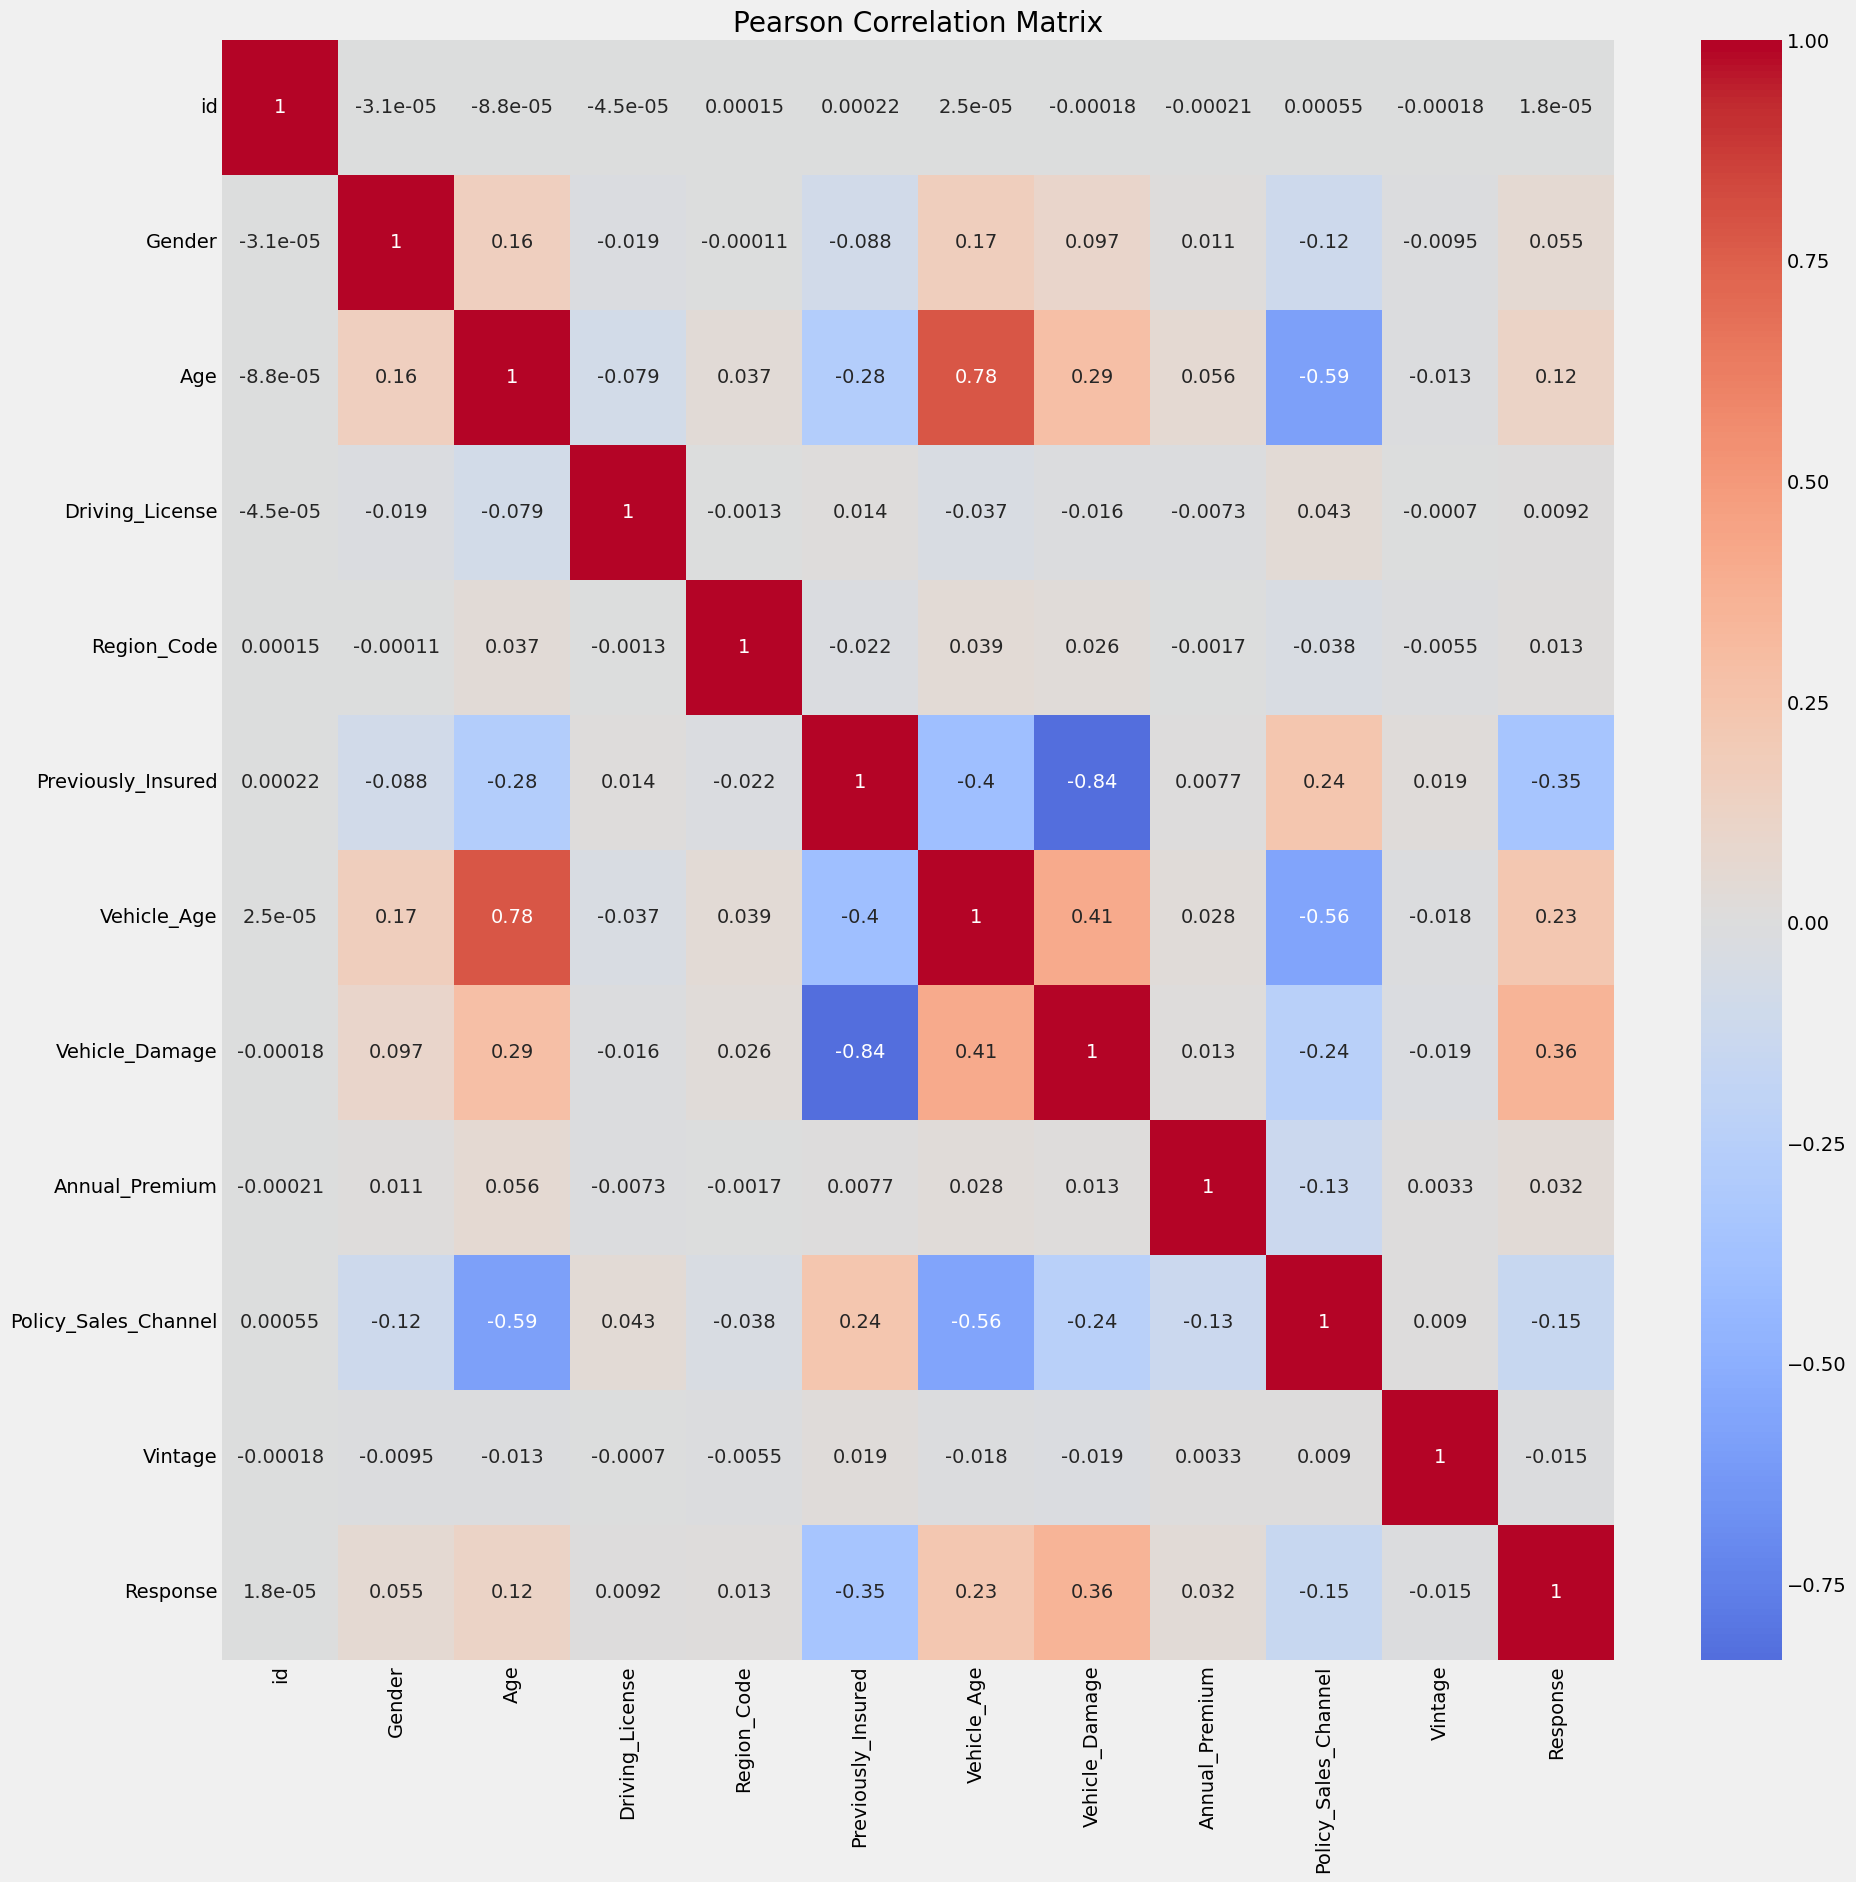

In [17]:
# Calculate the Pearson correlation matrix
corr_matrix = df_train.corr(method='pearson')

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation Matrix")
plt.show()

In [19]:
# Drop unimportant features
df_train = df_train.drop(['Gender', 'Driving_License'], axis=1)

<h3>8. Handling Outliers </h3>

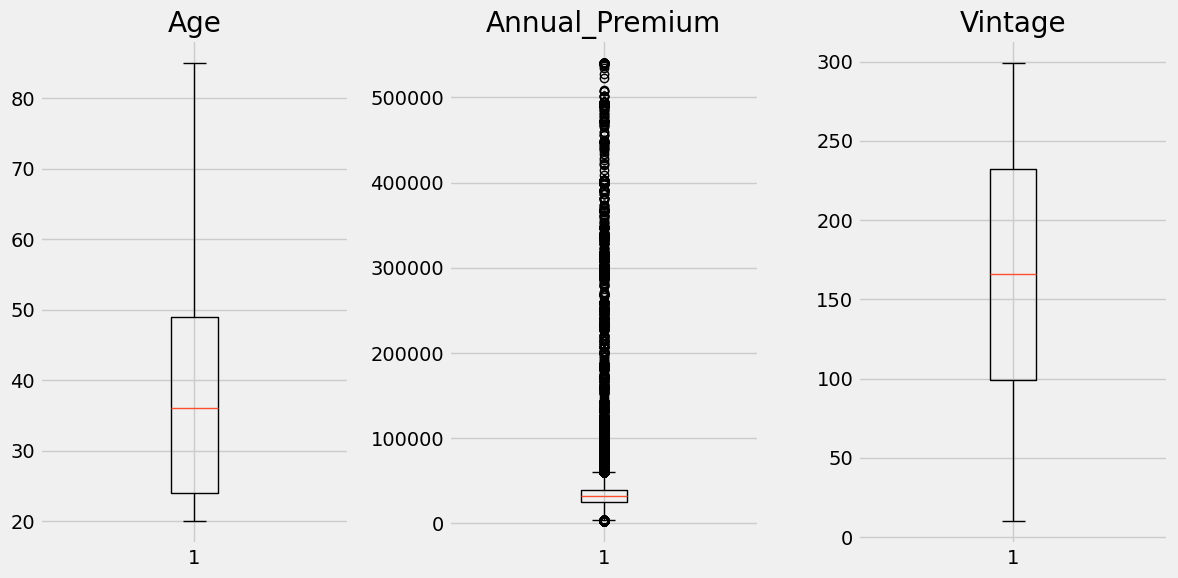

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# Collect numerical features
features = df_train[['Age', 'Annual_Premium', 'Vintage']]   
axs = axs.flatten()
for index, ft in enumerate(features):
    ax = axs[index]
    ax.boxplot(df_train[ft])
    ax.set_title(ft)
    ax.grid(True)
plt.tight_layout()
plt.show()


<h3>9. Split the Dataset</h3>

In [23]:
X = df_train.drop(columns=['Response','id'])
y = df_train['Response']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

<h3>10. Train Model</h3>

In [24]:
model = lgb.LGBMClassifier(
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("Validation ROC AUC Score:", auc)


[LightGBM] [Info] Number of positive: 1132047, number of negative: 8071791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122997 -> initscore=-1.964348
[LightGBM] [Info] Start training from score -1.964348
Validation ROC AUC Score: 0.8726111061296409
